# Assessment of NPS Quiet Pavement data

This notebook carries out exploratory data analysis on the quiet pavement study data. There are two types of data considered:

- OBSI: Onboard sound intensity measurement from a fixed instrument on a measurement vehicle, traveling at 45 mph
- Passby: Road way observational data, where speed and vehicle type vary.

There are eight sites, and four pavement treatments; each pavement treatment is replicated at two sites. Sound intensity was measured pre-treatment aand post-treatment.

In the original assessment, overall the Type II microsurfacing was found to reduce overall sound intensity sound from OBSI measuremnts from 99.2 dB on average to 97.6. Other treatments did not on average reduce sound levels. 

The source data is `Data Summary QP Re-Analysis.xlsx` from 2019-06-13.

## Questions

1. The All Passby sheet seems wrong. It only has S07 measurements from 2016, and the un-dated measurements (assumed to be post-treatment) are only S01-S04. Where are the other pre-treatment data (besides S07) and the other post-treatment data (besides S01-04)?

2. Are `airTemp` and `pavetemp` available for post-treamtent passby data?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from cycler import cycler
import statsmodels.api as sm
from sklearn import linear_model

OBSI DATA

In [2]:
#Transform OBSI into column form, basic dataframe
OBSI = pd.read_excel("C:\\Quiet_Pavement_Local\\Data Summary QP Re-Analysis.xlsx", sheet_name = "ALL OBSI", header = 1).T
OBSI.rename_axis(None,axis=1, inplace = True)
OBSI.drop([0,4], axis = 1, inplace = True)
OBSI.columns = OBSI.iloc[0]
OBSI = OBSI[1:]
OBSI.reset_index(inplace = True)
OBSI.drop(["index"], axis = 1, inplace = True)
OBSI.columns.name = None

#Adds pavement type into dataframe
#Turn values into a lists if you want to add other metadata
pavement_type = {
    1: "3/8in Chip Seal",
    2: "1/4in Chip Seal",
    3: "Type II Microsurfacing",
    4: "Type III Microsurfacing",
    5: "3/8in Chip Seal",
    6: "Type III Microsurfacing",
    7: "Type II Microsurfacing",
    8: "1/4in Chip Seal"
}

p_type_col = []
for s, y in zip(OBSI["Site"],OBSI["Measurement Year"]):
    if y == 0:
        p_type_col.append("3/8in Chip Seal")
    else:
        p_type_col.append(pavement_type[s])
OBSI["Pavement Type"]=p_type_col

macro_pavement_type = {
    1: "Chip Seal",
    2: "Chip Seal",
    3: "Microsurfacing",
    4: "Microsurfacing",
    5: "Chip Seal",
    6: "Microsurfacing",
    7: "Microsurfacing",
    8: "Chip Seal"
}

m_p_type_col = []
for s, y in zip(OBSI["Site"],OBSI["Measurement Year"]):
    if y == 0:
        m_p_type_col.append("Chip Seal")
    else:
        m_p_type_col.append(macro_pavement_type[s])
        
OBSI["Macro Pavement Type"]=m_p_type_col
OBSI["Site"] = OBSI["Site"].astype(str)

In [3]:
#Group data by year, site, pavement type, and replicates
OBSI_grouped = OBSI.set_index(["Measurement Year", "Site", "Pavement Type","Replicates", "Macro Pavement Type"])
OBSI_grouped= OBSI_grouped.swaplevel("Pavement Type", "Site") # Use this to swap levels
OBSI_grouped.sort_index(inplace=True) #necessary step to be able to use .loc and slice dataframes
OBSI_grouped = OBSI_grouped.astype(float)
OBSI_grouped

250  \
Measurement Year Pavement Type           Site Replicates Macro Pavement Type              
0                3/8in Chip Seal         1    1          Chip Seal            78.272962   
                                              2          Chip Seal            77.424128   
                                              3          Chip Seal            77.503556   
                                              4          Chip Seal            77.594450   
                                         2    1          Chip Seal            78.134415   
                                              2          Chip Seal            78.871586   
                                              3          Chip Seal            77.950447   
                                              4          Chip Seal            78.402812   
                                         3    1          Chip Seal            75.047623   
                                              2          Chip Seal            75.163727   
                                              3          Chip Seal            76.544013   
                                         4    1          Chip Seal            81.132513   
                                              2          Chip Seal            82.189725   
                                              3          Chip Seal            81.479575   
                                         5    1          Chip Seal            76.206128   
                                              2          Chip Seal            75.079422   
                                              3          Chip Seal            76.107714   
                                         6    2          Chip Seal            83.534950   
                                              3          Chip Seal            83.777596   
                                         7    1          Chip Seal            82.795095   
                                              2          Chip Seal            81.888315   
                                              3          Chip Seal            82.849268   
                                              4          Chip Seal            82.168847   
                                         8    1          Chip Seal            82.175721   
                                              2          Chip Seal            80.747433   
                                              3          Chip Seal            81.462971   
                                              4          Chip Seal            81.133165   
1                1/4in Chip Seal         2    1          Chip Seal            81.153424   
                                              2          Chip Seal            83.658388   
                                              3          Chip Seal            83.119201   
                                         8    1          Chip Seal            81.329238   
                                              2          Chip Seal            81.329238   
                                              3          Chip Seal            81.983753   
                                              4          Chip Seal            80.067849   
                                              5          Chip Seal            81.026652   
                                              6          Chip Seal            82.113862   
                                              7          Chip Seal            80.849675   
                 3/8in Chip Seal         1    1          Chip Seal            83.887058   
                                              2          Chip Seal            83.705899   
                                              3          Chip Seal            83.810148   
                                         5    1          Chip Seal            84.528425   
                                              2          Chip Seal            84.391510   
                                              3          Chip Seal            84

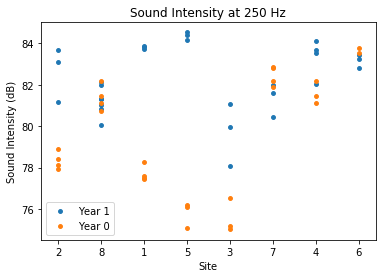

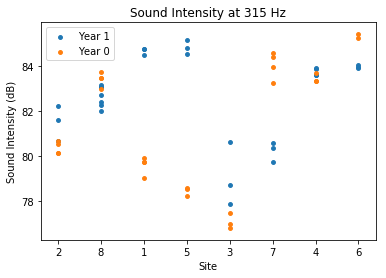

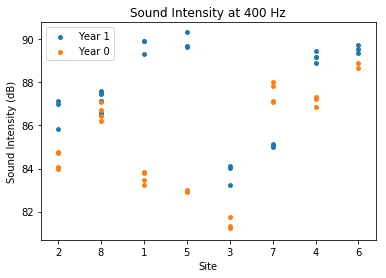

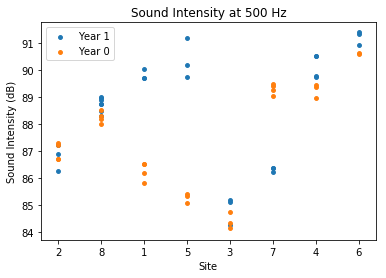

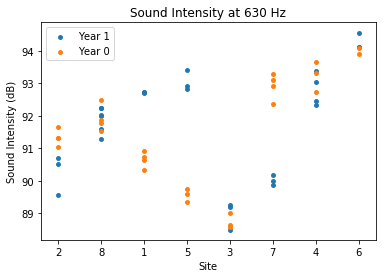

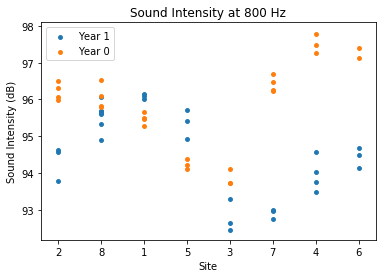

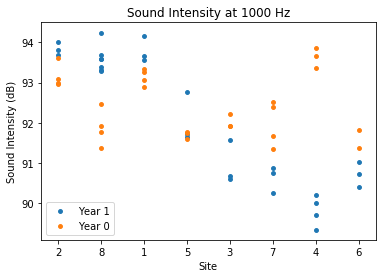

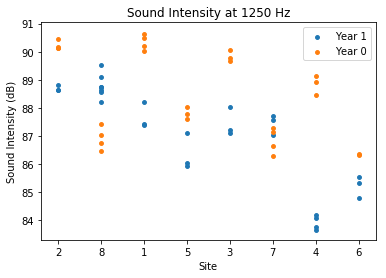

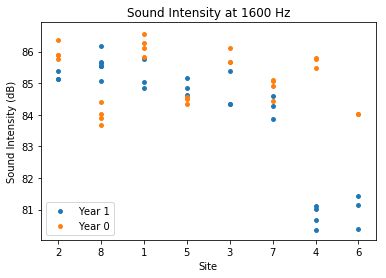

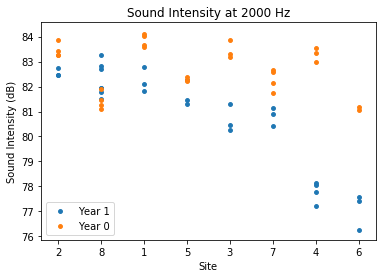

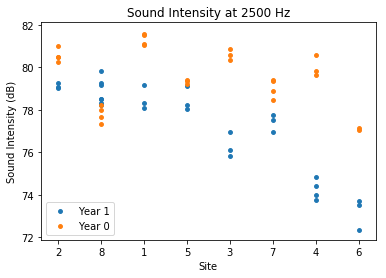

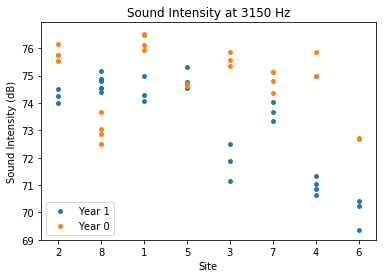

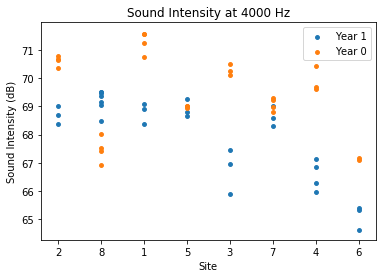

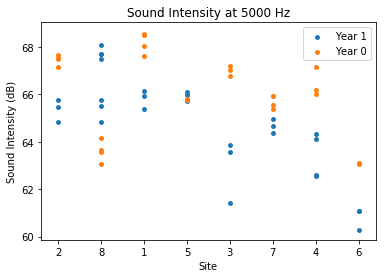

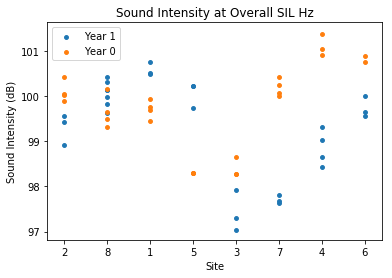

In [4]:
# Plot data by site and sound intensity. Each figure is a different frequency
# Last column describes pavement treatment type
# Blue = pre-treatment, Orange = post treatment.

# 2, 8: 1/4 inch chip seal
# 1, 5: 3/4 inch chip seal
# 3, 7: Type II Microsurfacing
# 4, 6: Type III Microsurfacing

#Separate data by year and use sites sorted by pavement type for plotting
yr0OBSI = OBSI_grouped.loc[0]
yr1OBSI = OBSI_grouped.loc[1]

for freq in yr0OBSI.columns:
    plt.figure()
    plt.scatter(yr1OBSI.index.get_level_values("Site"), yr1OBSI[freq], s = 15, label = "Year 1")
    plt.scatter(yr0OBSI.index.get_level_values("Site"), yr0OBSI[freq], s = 15, label = "Year 0")
    plt.title("Sound Intensity at " + str(freq) + " Hz")
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
    plt.legend()
#     plt.ylim(58,105)

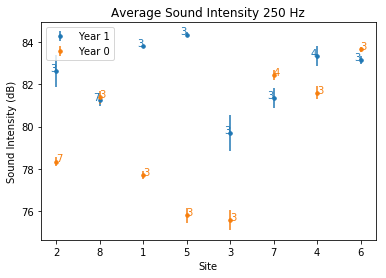

In [5]:
# Mean grouped by year and pavement type

# 2, 8: 1/4 inch chip seal
# 1, 5: 3/4 inch chip seal
# 3, 7: Type II Microsurfacing
# 4, 6: Type III Microsurfacing

#Take grouped means across replicates and macro pavement type
#Year, pavement type, and site presevered
OBSI_mean_by_pavement = OBSI_grouped.groupby(level = [0,1,2]).mean()
OBSI_sem_by_pavement = OBSI_grouped.groupby(level = [0,1,2]).sem()
OBSI_count_by_pavement = OBSI_grouped.groupby(level = [0,1,2]).count()

#Get dataframes of each year
year0_mean = OBSI_mean_by_pavement.loc[0]
year0_count = OBSI_count_by_pavement.loc[0]
year1_mean = OBSI_mean_by_pavement.loc[1]
year1_count = OBSI_count_by_pavement.loc[1]

#PLOT
for freq in OBSI_mean_by_pavement.columns:
    plt.figure()
    
    site = list(year1_mean.index.get_level_values(1))
    db = list(year1_mean[freq])
    sem = OBSI_sem_by_pavement.loc[1][freq]
    count =  list(year1_count[freq].values)
    
    plt.errorbar(site,db,sem, ls = "None",marker = ".",color = "#1f77b4", ms = 7, label = "Year 1")
    for i, txt in enumerate(count):
        plt.annotate(txt,(site[i],db[i]), color = "#1f77b4", horizontalalignment="right")

        
    site = list(year0_mean.index.get_level_values(1))
    db = list(year0_mean[freq])
    sem = OBSI_sem_by_pavement.loc[0][freq]
    count =  list(year1_count[freq].values)
    
    plt.errorbar(site,db,sem, ls = "None",color = "#f77f0e", marker = ".", ms= 7, label = "Year 0")
    for i, txt in enumerate(count):
        plt.annotate(txt,(site[i],db[i]), color = "#f77f0e", horizontalalignment="left")
    
    plt.legend()
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
#     plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")
    break
    


In [6]:
# Obsolete due to changing Year 0 to just 3/8 inch chip seal
# # Mean grouped by year and site
# OBSI_mean_by_site = OBSI_grouped.groupby(level = [0,1]).mean()
# OBSI_yearly_sem = OBSI_grouped.groupby(level = [0,1]).sem()
# #Plot data by site and sound intensity averaged and separated by year
# for freq in OBSI_mean_by_site.columns:
#     plt.figure()
    
#     plt.errorbar(OBSI_mean_by_site.loc[0].index,OBSI_mean_by_site.loc[0][freq], 
#                 OBSI_yearly_sem.loc[0][freq], ls = "None",marker = ".", ms= 12, label = "Year 0")
    
#     plt.errorbar(OBSI_mean_by_site.loc[1].index,OBSI_mean_by_site.loc[1][freq],
#                 OBSI_yearly_sem.loc[1][freq], ls = "None",marker = ".", ms = 12, label = "Year 1")
    
#     plt.legend()
#     plt.xlabel("Site")
#     plt.ylabel("Sound Intensity (dB)")
#     plt.xticks(rotation = 10)
#     plt.ylim(58,105)
#     plt.title("Average Sound Intensity "+ str(freq) + " Hz")

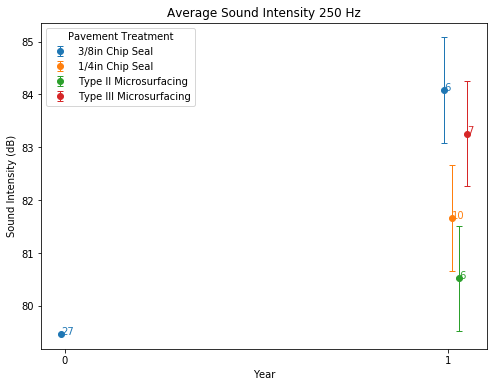

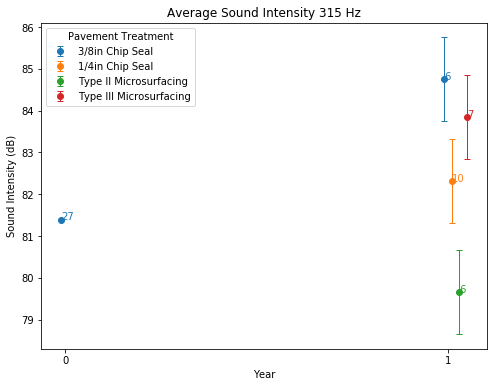

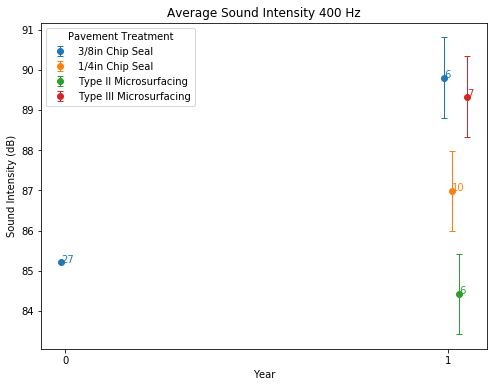

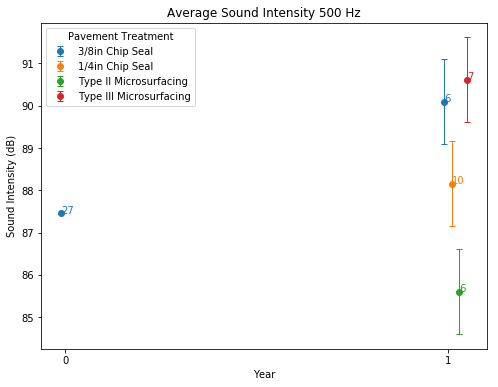

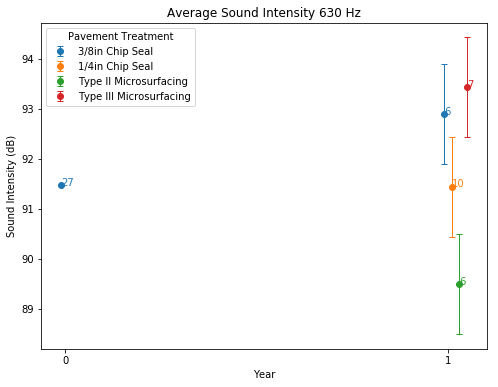

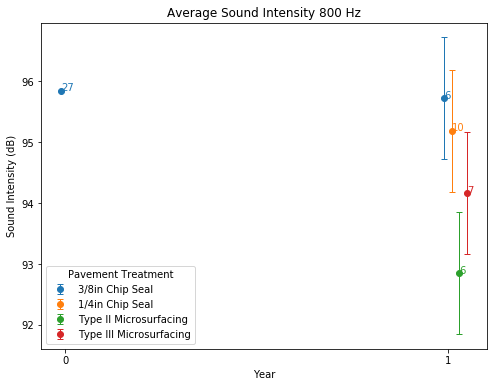

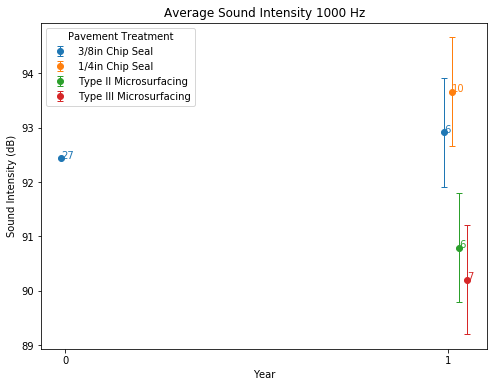

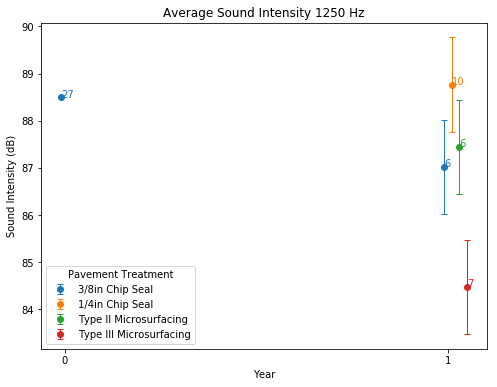

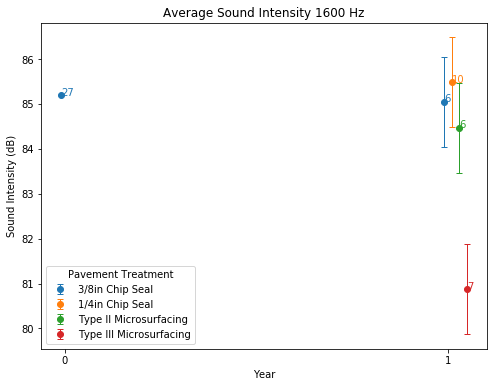

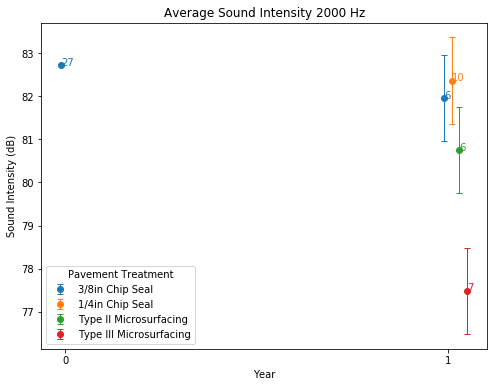

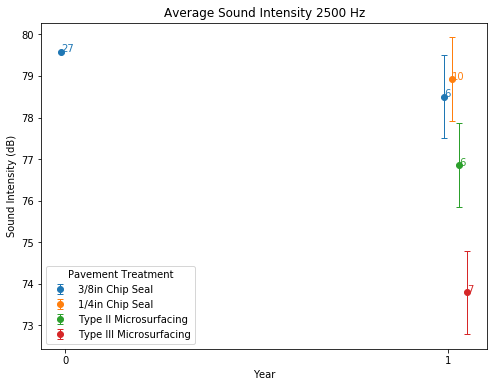

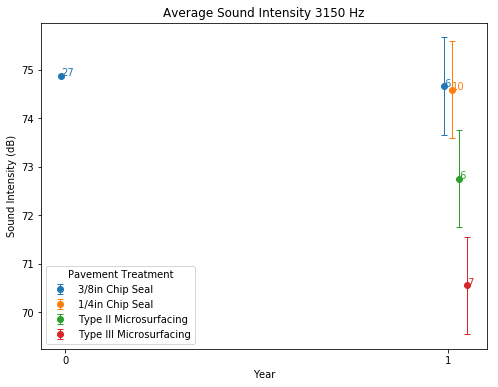

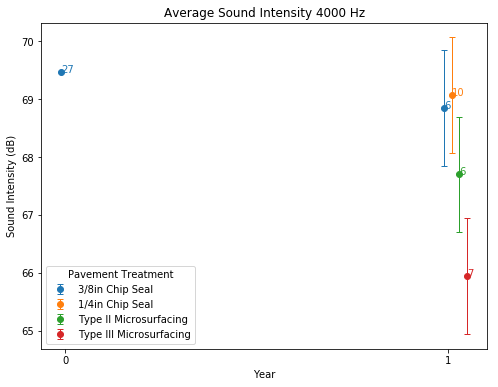

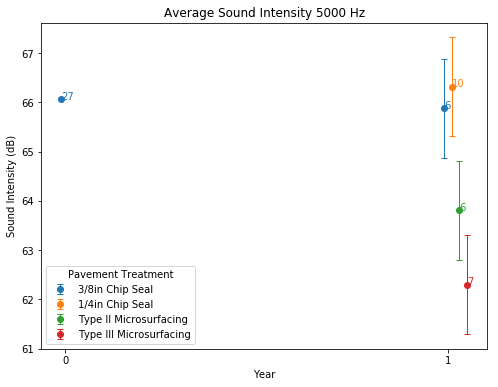

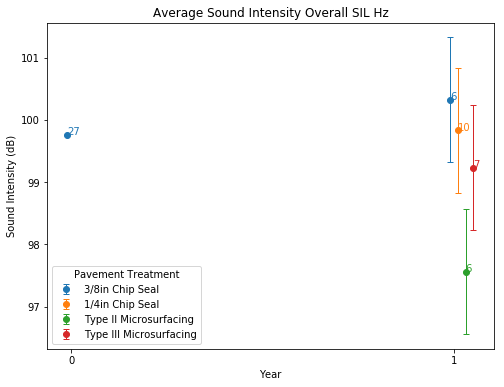

In [7]:
OBSI_mean_by_site = OBSI_grouped.groupby(level = [0,1]).mean().copy().swaplevel(0,1)
OBSI_yearly_sem = OBSI_grouped.groupby(level = [0,1]).sem().copy().swaplevel(0,1)
OBSI_count_by_site = OBSI_grouped.groupby(level = [0,1]).count().copy().swaplevel(0,1)
pavements = ["3/8in Chip Seal", "1/4in Chip Seal", "Type II Microsurfacing", "Type III Microsurfacing"]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']

for freq in OBSI_mean_by_site.columns:
    plt.figure(figsize = (8,6))
    for p, c in zip(pavements, colors):
        year = list(OBSI_mean_by_site.loc[p].index+0.02*pavements.index(p) - 0.01)
        db = list(OBSI_mean_by_site.loc[p][freq])
        sem = OBSI_yearly_sem.loc[p].index
        count =  list(OBSI_count_by_site.loc[p][freq].values)
        
        plt.errorbar(year,db,sem,ls = "None",marker = ".", capsize = 3, ms= 12, 
                     elinewidth = 1, label = p, color = c)
        
        for i, txt in enumerate(count):
            plt.annotate(txt, (year[i], db[i]), color = c)
        
        
        plt.xticks([0,1])
        plt.xlabel("Year")
        plt.ylabel("Sound Intensity (dB)")
        plt.title("Average Sound Intensity " + str(freq) + " Hz")
        plt.legend(title = "Pavement Treatment")

In [8]:
# # Obsolete due to changing Year 0 to just 3/8 inch chip seal
# # Mean grouped by macro pavement types, chip seal and microsurfacing

# #Take grouped means across pavement type, replicates, and site
# #Year and macro pavement type preserved
# OBSI_mean_by_macro = OBSI_grouped.groupby(level = [0,4]).mean()
# OBSI_sem_by_macro = OBSI_grouped.groupby(level = [0,4]).sem()
# #Get dataframes of each year
# year0_mean = OBSI_mean_by_macro.loc[(0)]
# year1_mean = OBSI_mean_by_macro.loc[(1)]

# #PLOT
# for freq in OBSI_mean_by_pavement.columns:
#     plt.figure()
    
#     plt.errorbar(year0_mean.index ,year0_mean[freq], 
#                 OBSI_sem_by_macro.loc[0][freq], ls = "None",marker = ".", ms= 7, label = "Year 0")
    
#     plt.errorbar(year1_mean.index, year1_mean[freq],
#                 OBSI_sem_by_macro.loc[1][freq], ls = "None",marker = ".", ms = 7, label = "Year 1")
    
#     plt.legend(loc = "upper center")
#     plt.xlabel("Site")
#     plt.ylabel("Sound Intensity (dB)")
#     plt.xticks(rotation = 15)
# #     plt.ylim(58,105)
#     plt.title("Average Sound Intensity "+ str(freq) + " Hz")

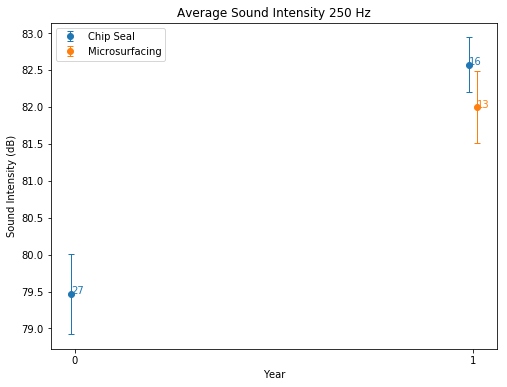

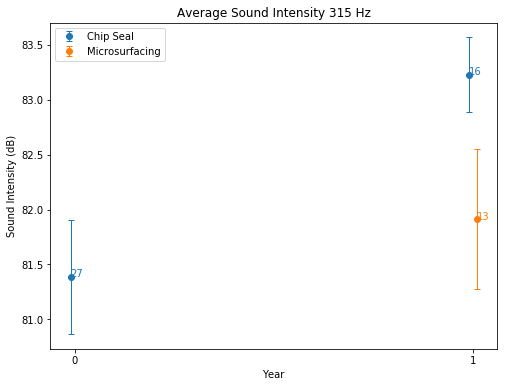

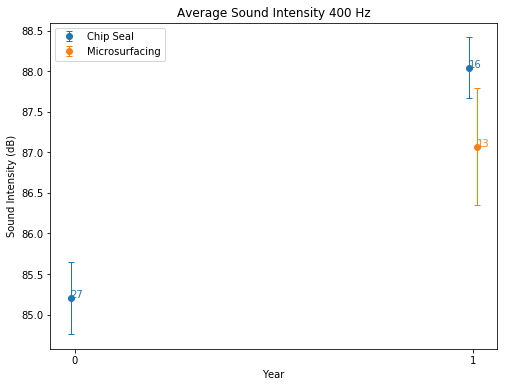

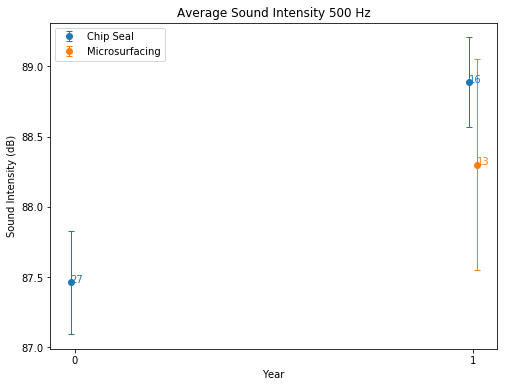

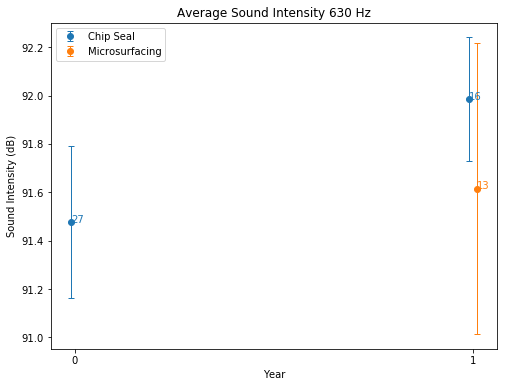

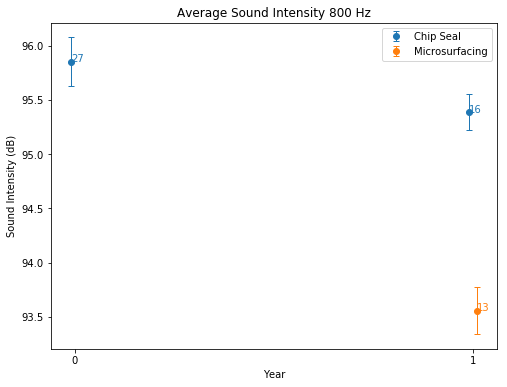

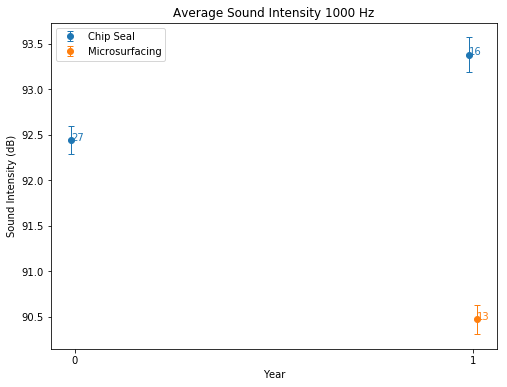

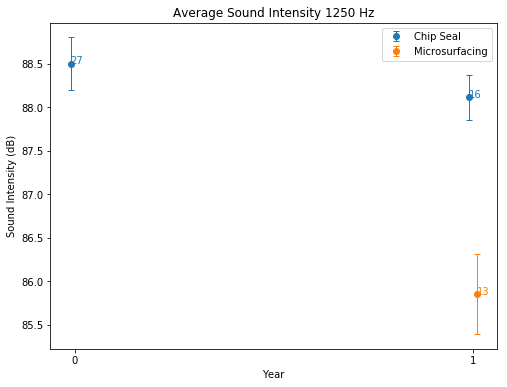

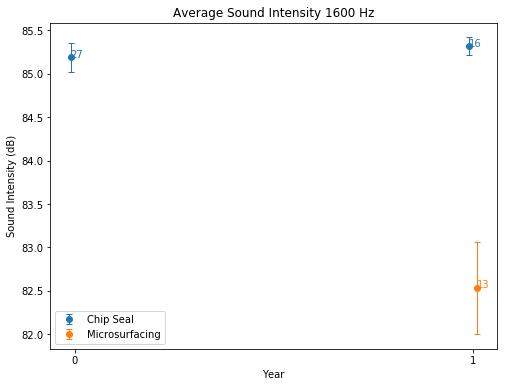

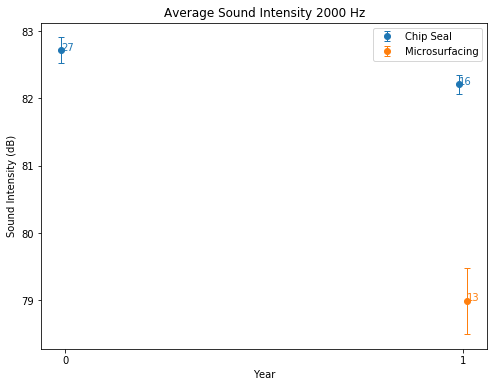

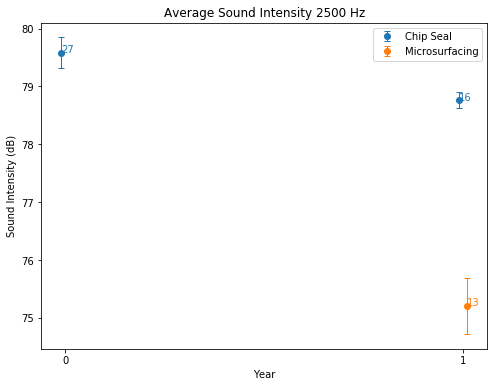

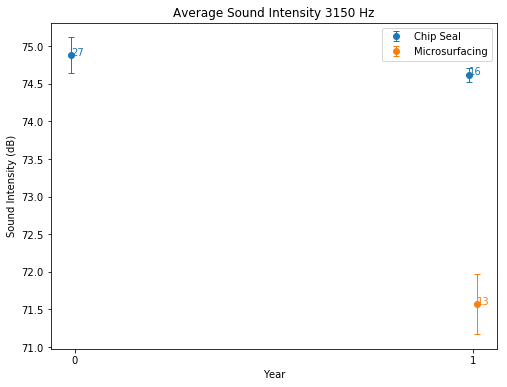

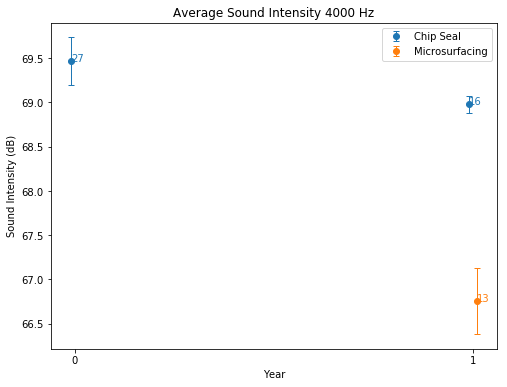

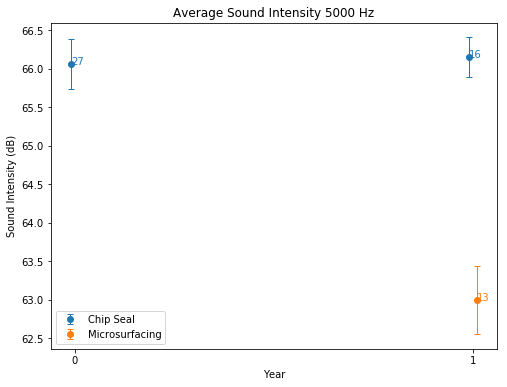

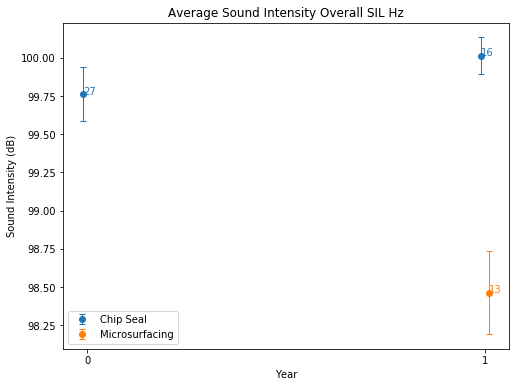

In [9]:
# Obsolete due to changing Year 0 to just 3/8 inch chip seal
# Mean grouped by macro pavement types, chip seal and microsurfacing

#Take grouped means across pavement type, replicates, and site
#Year and macro pavement type preserved
OBSI_mean_by_macro = OBSI_grouped.groupby(level = [0,4]).mean().copy().swaplevel(0,1)
OBSI_sem_by_macro = OBSI_grouped.groupby(level = [0,4]).sem().copy().swaplevel(0,1)
OBSI_count_by_macro = OBSI_grouped.groupby(level = [0,4]).count().copy().swaplevel(0,1)
macro_pavements = ["Chip Seal", "Microsurfacing"]

colors = ['#1f77b4','#ff7f0e']
for freq in OBSI_mean_by_pavement.columns:
    plt.figure(figsize = (8,6))
    for p,c in zip(macro_pavements, colors):
        year = list(OBSI_mean_by_macro.loc[p].index+0.02*macro_pavements.index(p) - 0.01)
        db = list(OBSI_mean_by_macro.loc[p][freq])
        sem = OBSI_sem_by_macro.loc[p][freq]
        count = list(OBSI_count_by_macro.loc[p][freq])
        
        plt.errorbar(year,db,sem, ls = "None",marker = ".", capsize = 3, ms= 12, 
                     elinewidth = 1, label = p, color = c)
        
        for i, txt in enumerate(count):
            plt.annotate(txt,(year[i], db[i]),color = c)
            
    plt.xticks([0,1])
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Sound Intensity (dB)")
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")


In [10]:
#Count how many datapoints are in each grouping
OBSI_counts_by_site =OBSI_grouped.groupby(level = [0,1]).count()
OBSI_counts_by_pavement =OBSI_grouped.groupby(level = [0,2]).count()
OBSI_counts_by_pavement, OBSI_counts_by_site

(                       250  315  400  500  630  800  1000  1250  1600  2000  \
 Measurement Year Site                                                         
 0                1       4    4    4    4    4    4     4     4     4     4   
                  2       4    4    4    4    4    4     4     4     4     4   
                  3       3    3    3    3    3    3     3     3     3     3   
                  4       3    3    3    3    3    3     3     3     3     3   
                  5       3    3    3    3    3    3     3     3     3     3   
                  6       2    2    2    2    2    2     2     2     2     2   
                  7       4    4    4    4    4    4     4     4     4     4   
                  8       4    4    4    4    4    4     4     4     4     4   
 1                1       3    3    3    3    3    3     3     3     3     3   
                  2       3    3    3    3    3    3     3     3     3     3   
                  3       3    3    3   

In [11]:
#Transform data to look at all frequences for each site
#Group data by site, year, and pavement type
OBSIfreq = OBSI_grouped.T

# OBSIfreq_mean_type = OBSIfreq[:14].groupby(level = [1],axis = 1).mean()
OBSIfreq_mean_site = OBSIfreq[:14].groupby(level = [2],axis = 1).mean()
OBSIfreq_mean_yr_type = OBSIfreq[:14].groupby(level = [0,1],axis = 1).mean()
OBSIfreq_mean_yr_site = OBSIfreq[:14].groupby(level = [0,2],axis = 1).mean()
OBSIfreq_mean_yr_macro = OBSIfreq[:14].groupby(level = [0,4],axis = 1).mean()

# OBSIfreq_sem_type = OBSIfreq[:14].groupby(level = [1],axis = 1).sem()
OBSIfreq_sem_site = OBSIfreq[:14].groupby(level = [2],axis = 1).sem()
OBSIfreq_sem_yr_type = OBSIfreq[:14].groupby(level = [0,1],axis = 1).sem()
OBSIfreq_sem_yr_site = OBSIfreq[:14].groupby(level = [0,2],axis = 1).sem()
OBSIfreq_sem_yr_macro = OBSIfreq[:14].groupby(level = [0,4],axis = 1).sem()

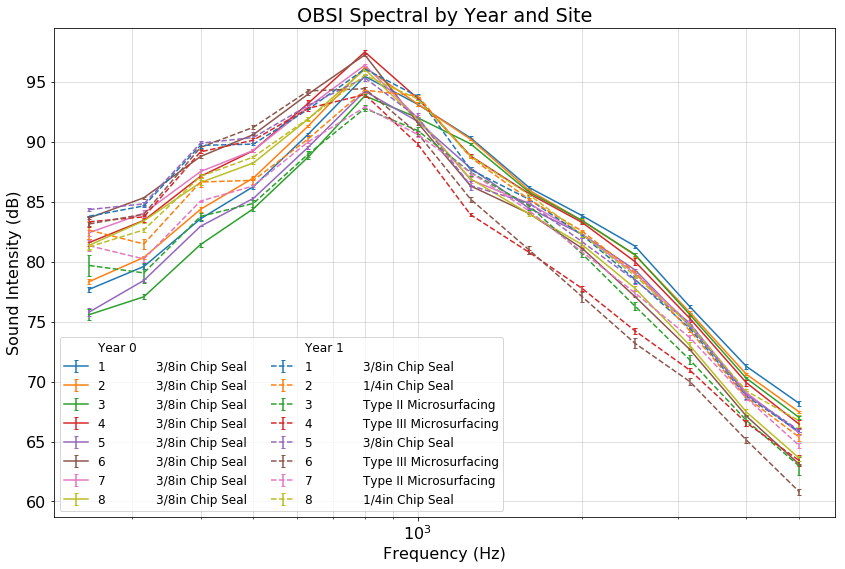

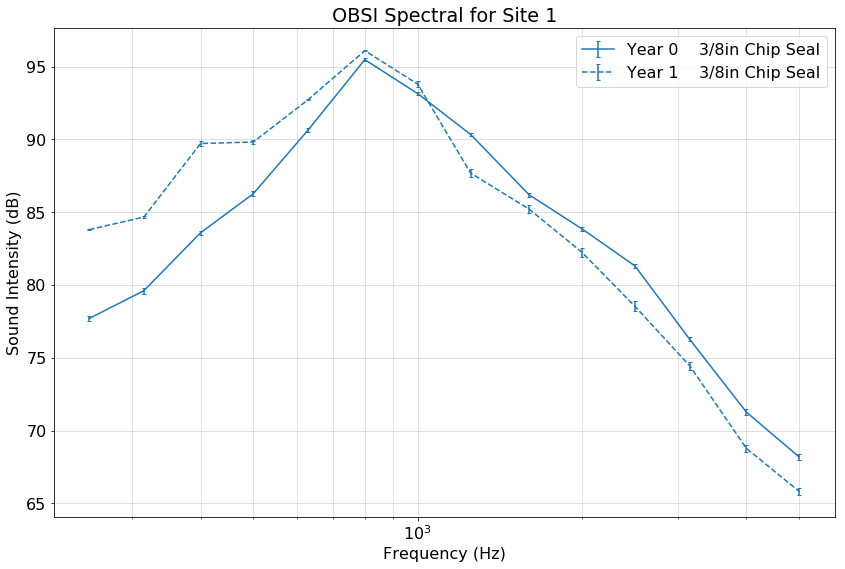

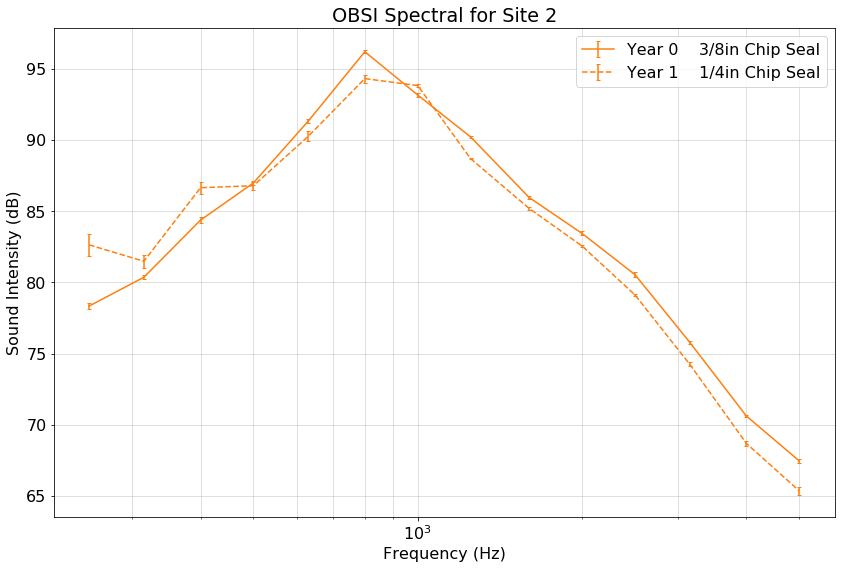

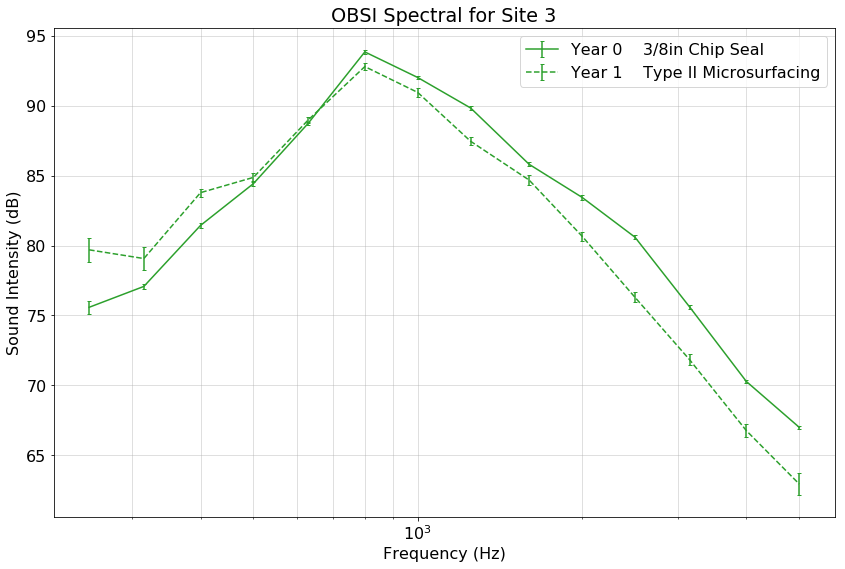

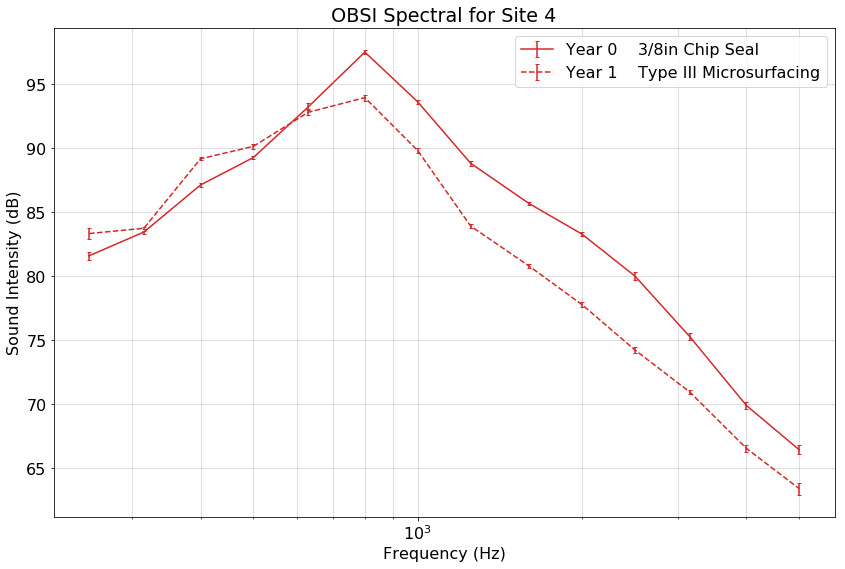

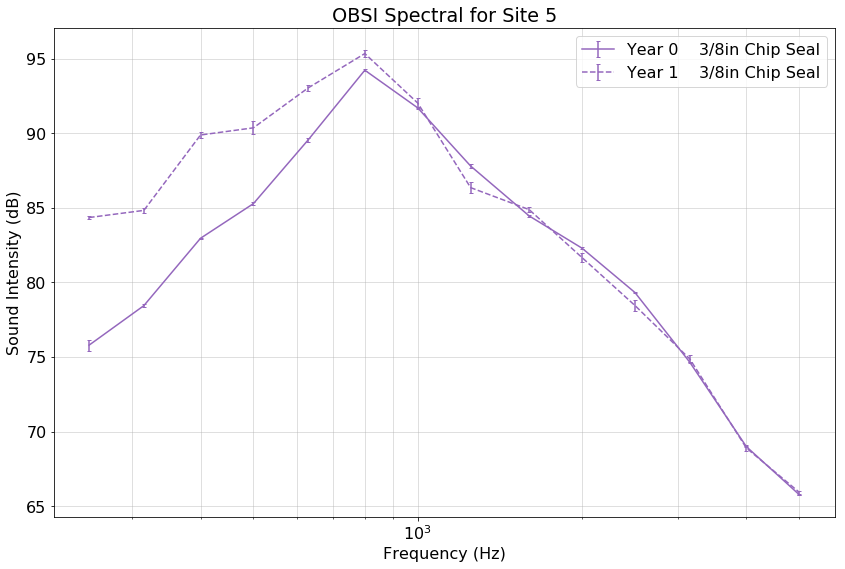

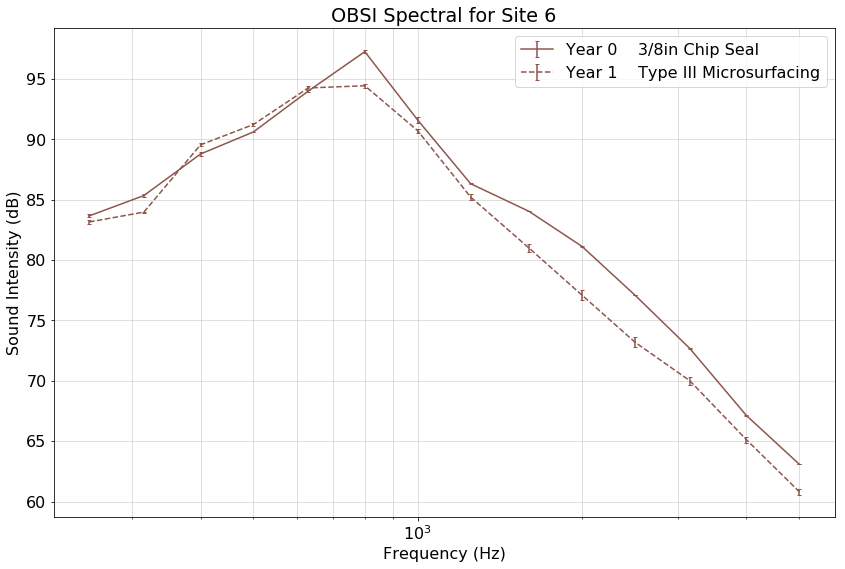

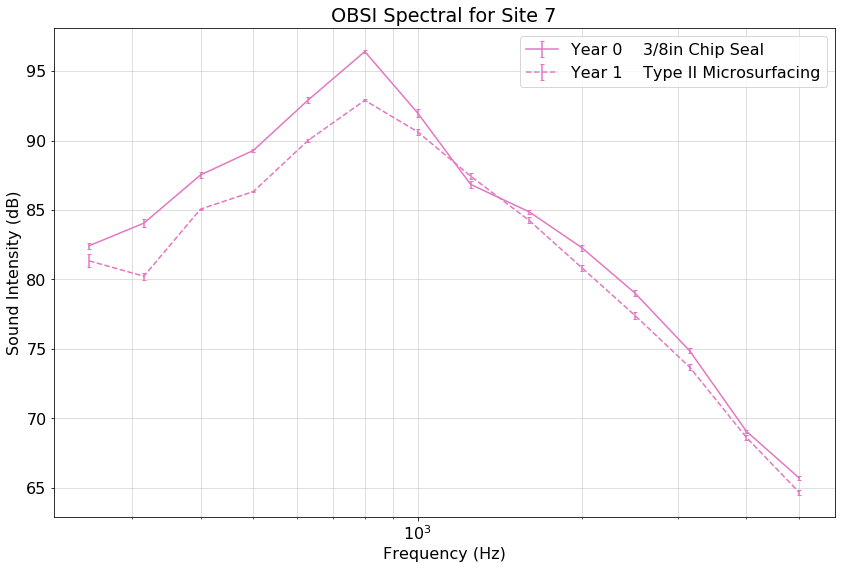

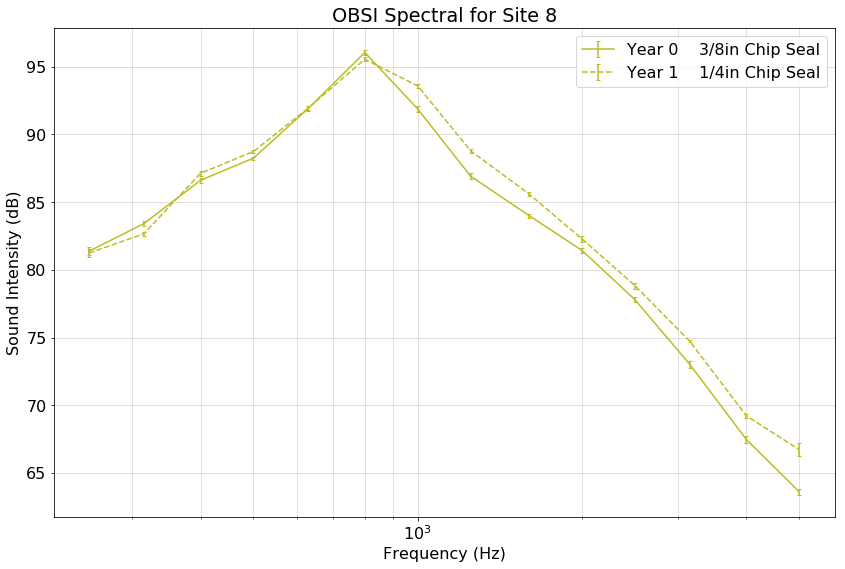

In [12]:
#Figures separated by year and site
plt.figure(figsize = (14,9))
plt.rcParams.update({"font.size":16})
plt.rc("axes", prop_cycle=(cycler('color',['#1f77b4','#ff7f0e','#2ca02c','#d62728',
                                          '#9467bd','#8c564b','#e377c2', '#bcbd22'])))

for yr in [0,1]:
    for s in range(1,9):
        site = str(s)
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "-", label = str(site)+"             3/8in Chip Seal")
        else:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "--", label = str(site) + "             "+pavement_type[s])

h, l = plt.gca().get_legend_handles_labels()
ph = [plt.plot([], marker = "", ls = "")[0]]
handles = ph + h[0:int(len(h)/2)]+ ph+ h[int(len(h)/2):]
labels = ["Year 0"]+l[0:int(len(h)/2)]+["Year 1"]+l[int(len(h)/2):]

plt.grid(which = "both", alpha = 0.5)
plt.legend(handles, labels,  prop={'size': 12}, ncol = 2)
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral by Year and Site")
plt.xscale("log")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")

#Site Comparisons
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2', '#bcbd22']
for s, col in zip(range(1,9), colors):
    site = str(s)
    plt.figure(figsize = (14,9))
    for yr in [0,1]:
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "-", label = "Year 0    "+"3/8in Chip Seal", color = col)
        else:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "--", label = "Year 1    "+pavement_type[s], color = col)

    plt.legend()
    plt.grid(which = "both", alpha = 0.5)
    plt.title("OBSI Spectral for Site " + str(site))
    plt.xscale("log")
    plt.ylabel("Sound Intensity (dB)")
    plt.xlabel("Frequency (Hz)")

250     84.078751
315     84.751021
400     89.803023
500     90.096654
630     92.891096
800     95.722634
1000    92.915316
1250    87.023540
1600    85.049950
2000    81.953540
2500    78.495607
3150    74.664763
4000    68.842089
5000    65.876056
Name: 3/8in Chip Seal, dtype: float64

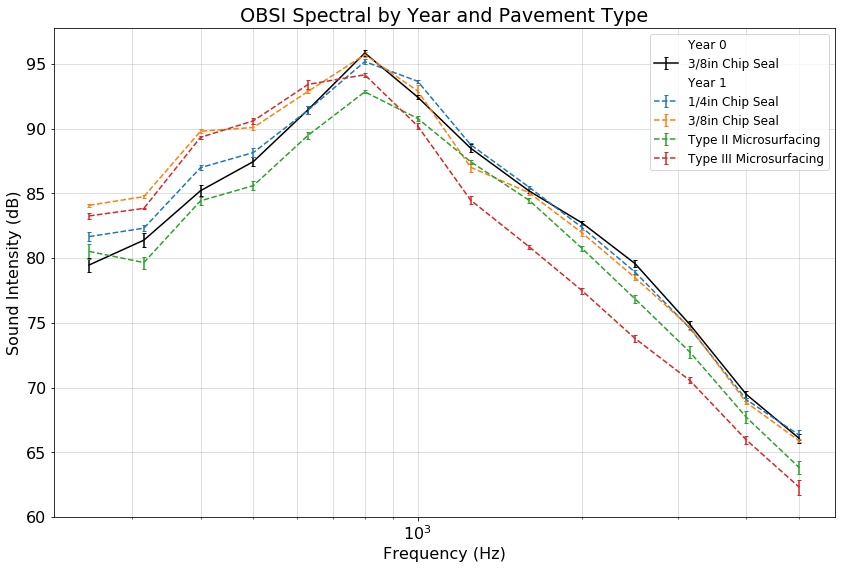

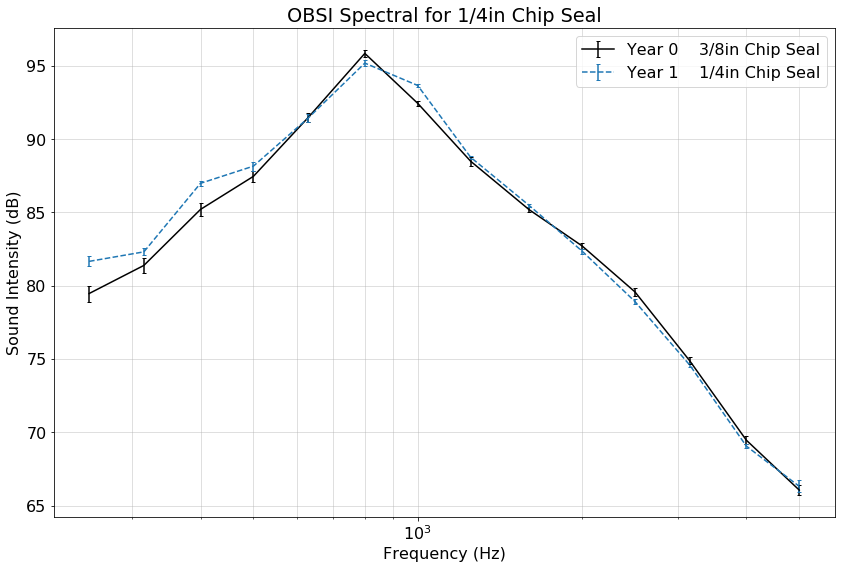

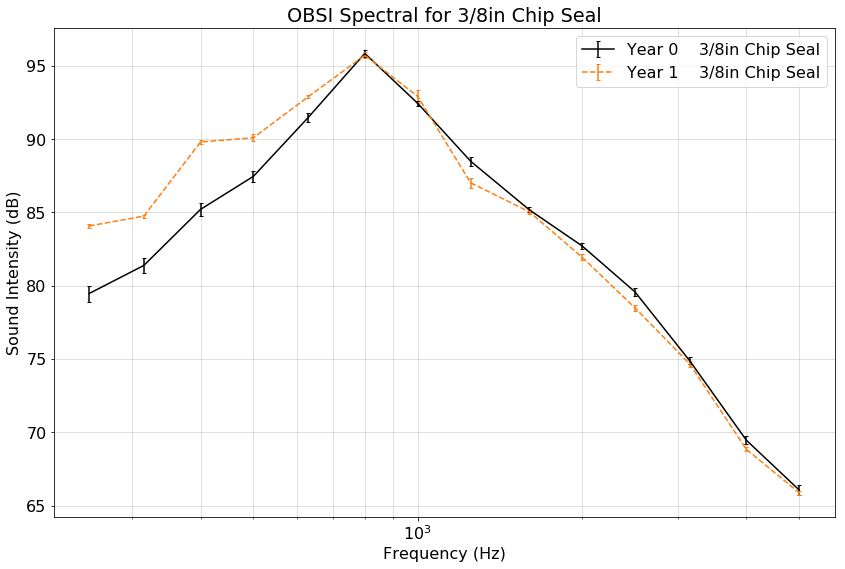

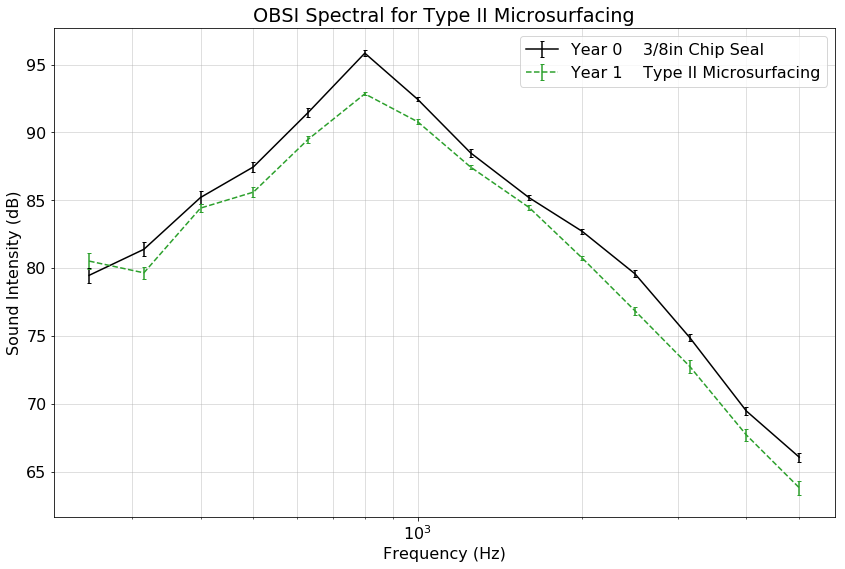

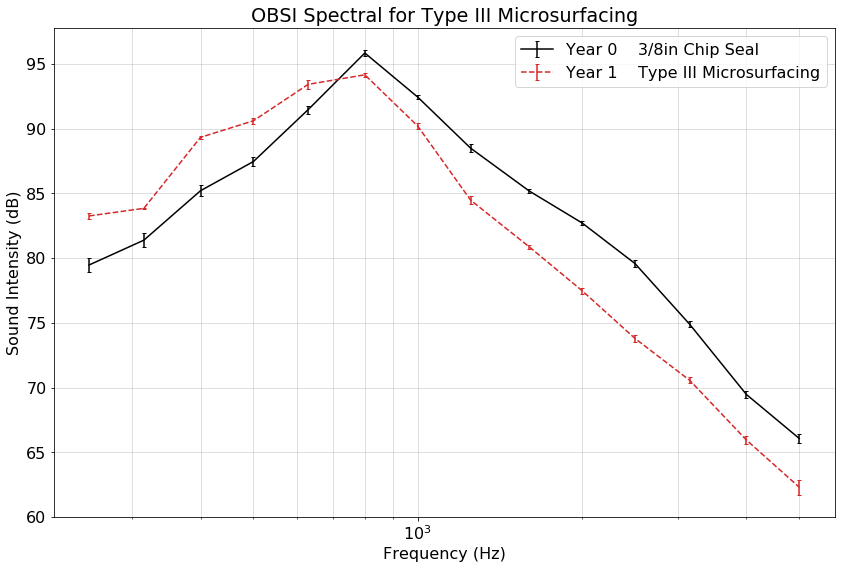

In [13]:
# #Figures for Year and Pavement Type Grouping

plt.figure(figsize = (14,9))
plt.rcParams.update({'font.size': 16})
plt.rc("axes", prop_cycle=(cycler('color',['#000000','#1f77b4','#ff7f0e','#2ca02c','#d62728'])))
for yr in [0,1]:
    for ptype in OBSIfreq_mean_yr_type.columns.levels[1]:
        if yr == 0:
            if ptype =='3/8in Chip Seal':
                plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2)
        else:
            plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2, linestyle = "--")

h, l = plt.gca().get_legend_handles_labels()
ph = [plt.plot([], marker = "", ls = "")[0]]
handles = ph + h[0:1]+ ph+ h[1:]
labels = ["Year 0"]+l[0:1]+["Year 1"]+l[1:]
plt.grid(which = "both", alpha = 0.5)
plt.legend(handles, labels,  prop={'size': 12})
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral by Year and Pavement Type")
plt.xscale("log")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")

#Site comparisons
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']
for ptype, col in zip(OBSIfreq_mean_yr_type.columns.levels[1], colors):
    plt.figure(figsize = (14,9))
    
    plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[0]["3/8in Chip Seal"],OBSIfreq_sem_yr_type[0]["3/8in Chip Seal"],
            capsize = 2, color = "k", label = "Year 0    3/8in Chip Seal")
    plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[1][ptype],OBSIfreq_sem_yr_type[1][ptype],
            capsize = 2, linestyle = "--", color = col, label = "Year 1    "+ptype)
    
    plt.grid(which = "both", alpha = 0.5)
    plt.legend()
    plt.title("OBSI Spectral for " + ptype)
    plt.xscale("log")
    plt.ylabel("Sound Intensity (dB)")
    plt.xlabel("Frequency (Hz)")
    
OBSIfreq_mean_yr_type[1]["3/8in Chip Seal"]

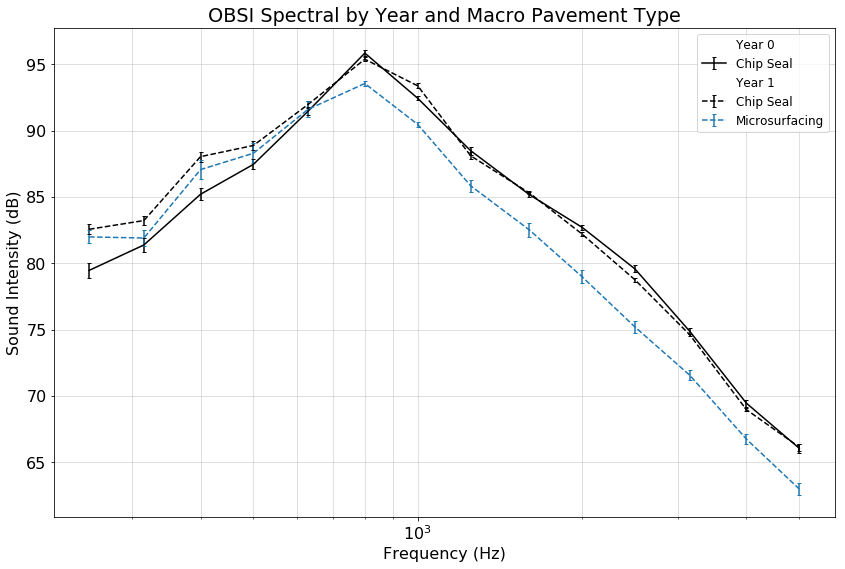

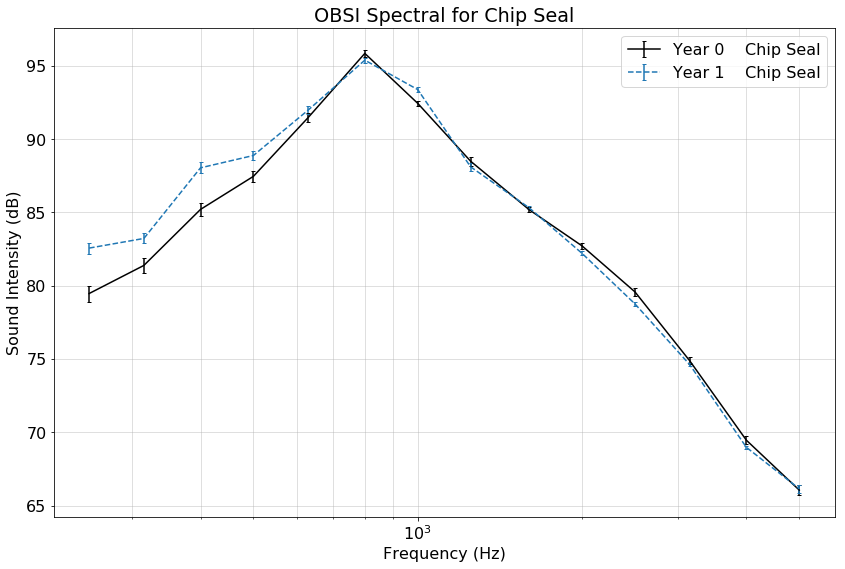

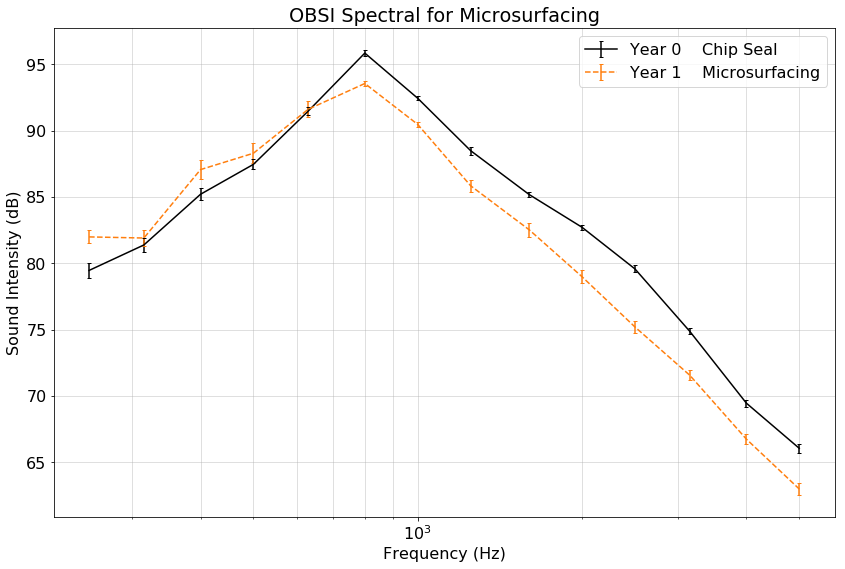

In [14]:
#Figures for Year and Macro Pavement Type Grouping
plt.figure(figsize = (14,9))
plt.rcParams.update({'font.size': 16})
for yr in [0,1]:
    for ptype in OBSIfreq_mean_yr_macro.columns.levels[1]:
        if yr == 0:
            if ptype == "Chip Seal":
                plt.errorbar(OBSIfreq_mean_yr_macro.index, OBSIfreq_mean_yr_macro[yr][ptype],OBSIfreq_sem_yr_macro[yr][ptype],
                        capsize = 2, color = "k")
        else:
            plt.errorbar(OBSIfreq_mean_yr_macro.index, OBSIfreq_mean_yr_macro[yr][ptype],OBSIfreq_sem_yr_macro[yr][ptype],
                    capsize = 2, linestyle = "--")

h, l = plt.gca().get_legend_handles_labels()
ph = [plt.plot([], marker = "", ls = "")[0]]
handles = ph + h[0:int(len(h)/2)]+ ph+ h[int(len(h)/2):]
labels = ["Year 0"]+l[0:int(len(h)/2)]+["Year 1"]+l[int(len(h)/2):]
plt.grid(which = "both", alpha = 0.5)
plt.legend(handles, labels,  prop={'size': 12})
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral by Year and Macro Pavement Type")
plt.xscale("log")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")

#Site comparisons
colors = ['#1f77b4','#ff7f0e']
for ptype, col in zip(OBSIfreq_mean_yr_macro.columns.levels[1], colors):
    plt.figure(figsize = (14,9))
    plt.errorbar(OBSIfreq_mean_yr_macro.index, OBSIfreq_mean_yr_macro[0]["Chip Seal"],OBSIfreq_sem_yr_macro[0]["Chip Seal"],
            capsize = 2, color = "k", label = "Year 0    Chip Seal")
    plt.errorbar(OBSIfreq_mean_yr_macro.index, OBSIfreq_mean_yr_macro[1][ptype],OBSIfreq_sem_yr_macro[1][ptype],
            capsize = 2, linestyle = "--", color = col, label = "Year 1    "+ptype)
    
    plt.grid(which = "both", alpha = 0.5)
    plt.legend()
    plt.title("OBSI Spectral for " + ptype)
    plt.xscale("log")
    plt.ylabel("Sound Intensity (dB)")
    plt.xlabel("Frequency (Hz)")    

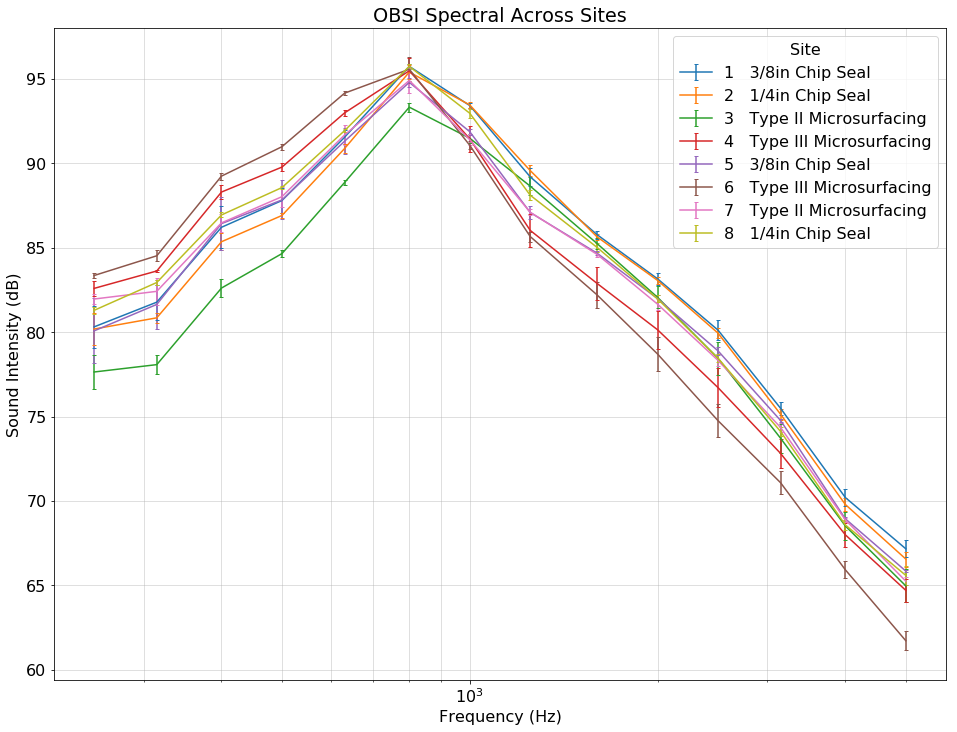

In [15]:
#Figures for site grouping
plt.figure(figsize = (16,12))
plt.rcParams.update({'font.size': 16})
plt.rc("axes", prop_cycle=(cycler('color',['#1f77b4','#ff7f0e','#2ca02c','#d62728',
                                          '#9467bd','#8c564b','#e377c2', '#bcbd22'])))
for site in OBSIfreq_mean_site.columns:
    plt.errorbar(OBSIfreq_mean_site.index, OBSIfreq_mean_site[site], OBSIfreq_sem_site[site],
                capsize = 2, label = str(site) + "   "+pavement_type[int(site)])
plt.xscale("log")
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral Across Sites")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")
plt.legend(title = "Site")

ALL PASSBY DATA

In [20]:
#Processes allpassby data, turns two row header into one row header as a tuple
allpassby = pd.read_excel("C:\\Quiet_Pavement_Local\\Data Summary QP Re-Analysis_rev2019 data.xlsx", sheet_name="All Passby", header =0)
allpassby.dropna(axis = 0, how = "all",inplace = True)
allpassby.dropna(axis = 1, how = "all", inplace = True)

allpassby_p_col = ["Pavement Type"]
for s, yr in zip(allpassby["Unnamed: 2"][1:], allpassby["Unnamed: 0"][1:]):
    if yr == 0:
        allpassby_p_col.append("3/8in Chip Seal")
    else:
         allpassby_p_col.append(pavement_type[float(s[2])])
allpassby["Pavement Type"] = allpassby_p_col

# Remove rows with non-number speed values
allpassby = allpassby[pd.concat([pd.Series([True]), allpassby.applymap(np.isreal)["Unnamed: 7"][1:]])]
# Remove rows with nan speed values
allpassby = allpassby[pd.concat([pd.Series([True]),~allpassby["Unnamed: 7"][1:].isnull()])]


allpassby_m_p_col = ["Macro Pavement Type"]
for s, yr in zip(allpassby["Unnamed: 2"][1:], allpassby["Unnamed: 0"][1:]):
    if yr == 0:
        allpassby_m_p_col.append("Chip Seal")
    else:
        allpassby_m_p_col.append(macro_pavement_type[float(s[2])])
allpassby["Macro Pavement Type"] = allpassby_m_p_col
allpassby.set_index(["Unnamed: 0","Macro Pavement Type", "Unnamed: 2", "Pavement Type"], inplace = True)

# Drop date, passtime, halfstep, vehtype, clean, Comment, winddir,
# cloud, ParkName, SiteName (the second one), and IntTemp
#These columns are either irrelevant, only exist for site 07, or are empty
allpassby.drop(["Unnamed: 1","Unnamed: 3","Unnamed: 4","Unnamed: 5","Unnamed: 6",
                "Unnamed: 8","Unnamed: 12","Unnamed: 13","Unnamed: 15","Unnamed: 16", "Unnamed: 22"], axis = 1, inplace = True)

# Drop accidentally copy/pasted frequency data
droplist = []
for i in range(97,133):
    droplist.append("Unnamed: "+str(i))
allpassby.drop(droplist, axis = 1, inplace = True)

#Create multilevel columns
header_corrections = []
for a,b in zip(allpassby.loc["Meas Year"].values.tolist()[0], allpassby.columns.tolist()):
    if isinstance(a,float):
        if "1/3 LZFeq" in b:
            header_corrections.append("1/3 LZFeq")
        else:
            header_corrections.append("1/3 LZFmax")
    else:
        header_corrections.append(a)
allpassby.columns = [header_corrections, allpassby.loc["Meas Year"].values.tolist()[0]]

#Remove column labels that are still inside the table
allpassby.drop([("Meas Year", "Macro Pavement Type", "sitename", "Pavement Type")],axis = 0, inplace = True)
allpassby

speed  \
                                                                  speed   
Unnamed: 0 Macro Pavement Type Unnamed: 2 Pavement Type                   
0          Chip Seal           S07        3/8in Chip Seal            39   
                                          3/8in Chip Seal            45   
                                          3/8in Chip Seal            45   
                                          3/8in Chip Seal            46   
                                          3/8in Chip Seal            46   
                                          3/8in Chip Seal            46   
                                          3/8in Chip Seal            46   
                                          3/8in Chip Seal            47   
                                          3/8in Chip Seal            47   
                                          3/8in Chip Seal            47   
                                          3/8in Chip Seal            48   
                                          3/8in Chip Seal            48   
                                          3/8in Chip Seal            49   
                                          3/8in Chip Seal            50   
                                          3/8in Chip Seal            50   
                                          3/8in Chip Seal            51   
                                          3/8in Chip Seal            51   
                                          3/8in Chip Seal            52   
                                          3/8in Chip Seal            55   
                                          3/8in Chip Seal            56   
                                          3/8in Chip Seal            57   
                                          3/8in Chip Seal            57   
                                          3/8in Chip Seal            60   
                                          3/8in Chip Seal            60   
                                          3/8in Chip Seal            60   
                                          3/8in Chip Seal            61   
                               S02        3/8in Chip Seal            47   
                                          3/8in Chip Seal            51   
                                          3/8in Chip Seal            55   
                                          3/8in Chip Seal            60   
...                                                                 ...   
2          Microsurfacing      S04        Type III Microsurfacing    53   
                                          Type III Microsurfacing    50   
                                          Type III Microsurfacing    41   
                                          Type III Microsurfacing    55   
                                          Type III Microsurfacing    60   
                                          Type III Microsurfacing    65   
                                          Type III Microsurfacing    72   
                                          Type III Microsurfacing    52   
                                          Type III Microsurfacing    51   
                                          Type III Microsurfacing    58   
                                          Type III Microsurfacing    54   
                                          Type III Microsurfacing    53   
                                          Type III Microsurfacing    51   
                                          Type III Microsurfacing    47   
                                          Type III Microsurfacing    53   
                                          Type III Microsurfacing    59   
                                          Type III Microsurfacing    67   
                                          Type III Microsurfacing    61   
                                          Type III Microsurfacing    62   
                                          Type III Microsurfacing    45   
                

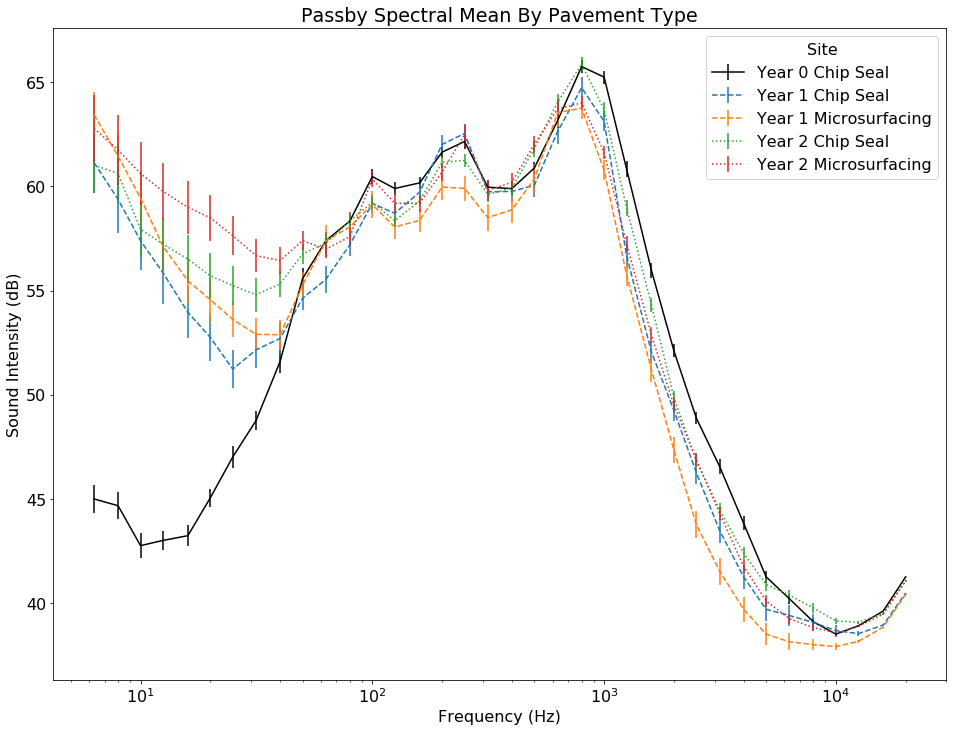

C:\Users\Janice.Shiu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: PerformanceWarning: indexing past lexsort depth may impact performance.
C:\Users\Janice.Shiu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: PerformanceWarning: indexing past lexsort depth may impact performance.


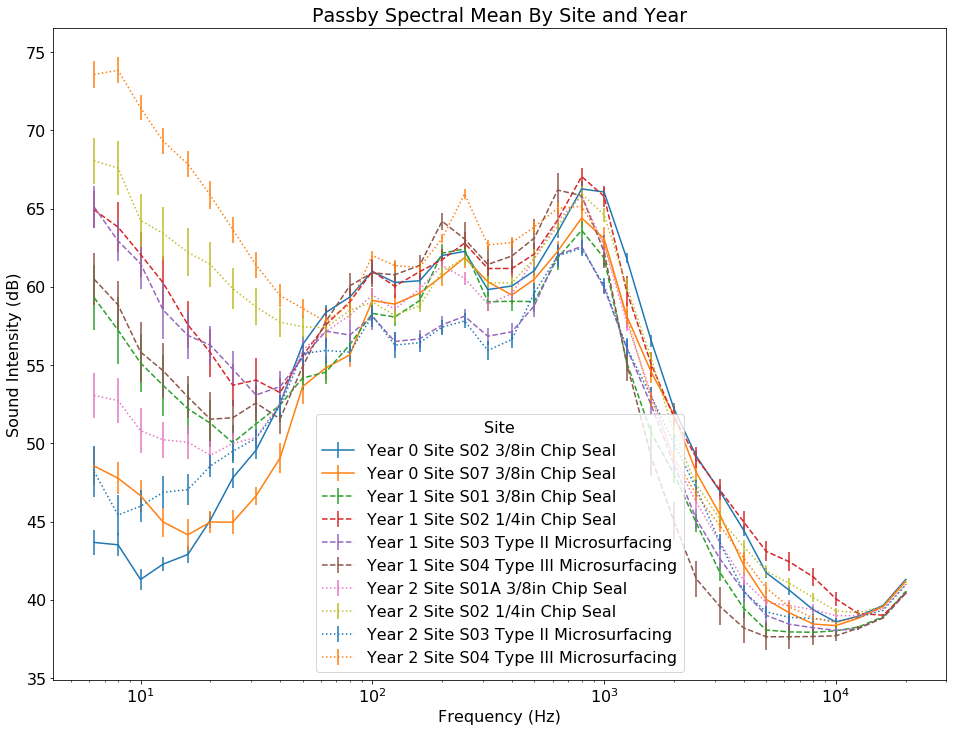

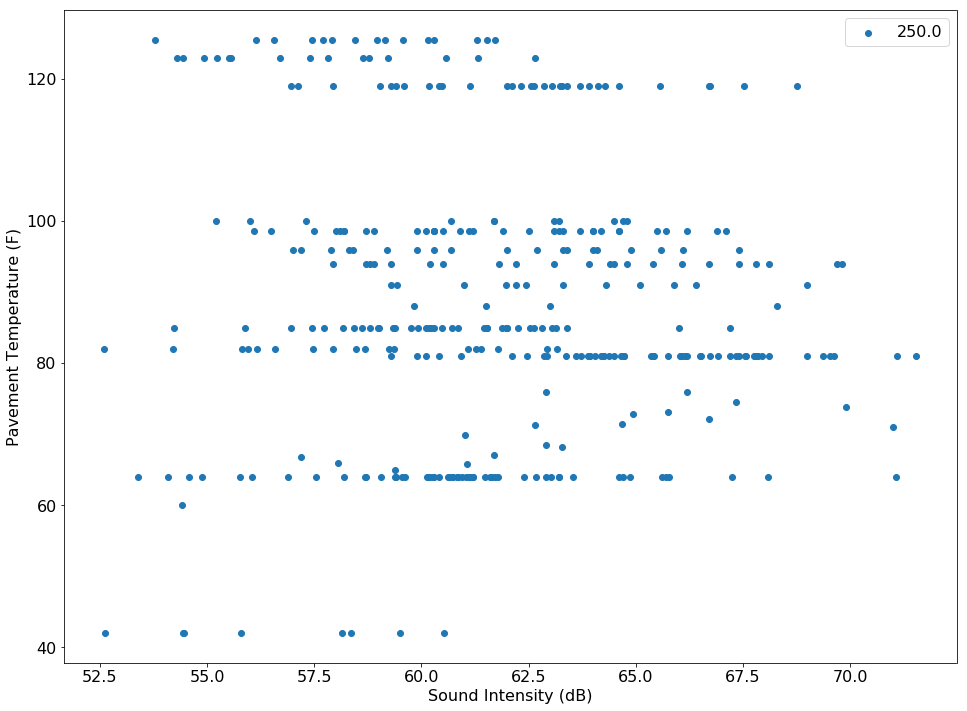

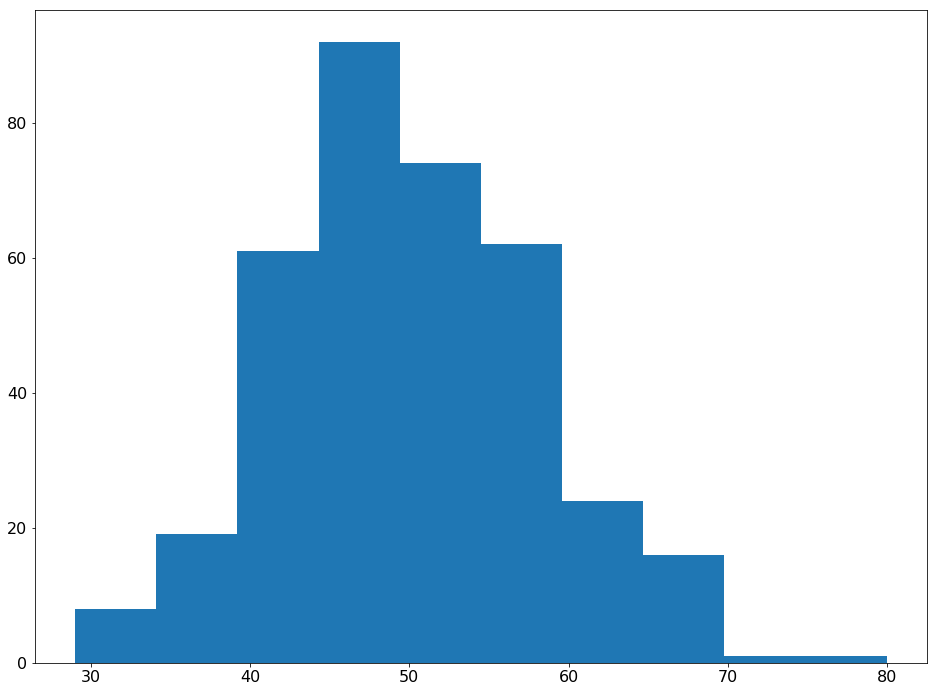

In [17]:
frequencies = allpassby["1/3 LZFeq"]
speed = allpassby["speed"]
pavetemp = allpassby["pavetemp"]

plt.figure(figsize = (16,12))
#iterate through years
for yr in allpassby.index.levels[0]:
    for macro in allpassby.index.levels[1]:
        if yr != "Meas Year" and macro != "Macro Pavement Type":

            try:
                mean = frequencies.loc[(yr, macro)].mean()
                sem = frequencies.loc[(yr, macro)].sem()
                if yr == 0:
                    if macro == "Chip Seal":
                        plt.errorbar(mean.axes[0], mean.values, sem.values, ls = "-",
                                     label = "Year " + str(yr) + " "+ macro, color = "k")
                elif yr == 1:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = "--",
                                 label = "Year " + str(yr) + " "+ macro)
                elif yr == 2:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = ":",
                                 label = "Year " + str(yr) + " "+ macro)

            except:
                continue


                
#Passby by Pavement Type
plt.title("Passby Spectral Mean By Pavement Type")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")
plt.xscale("log")
plt.legend(title = "Site")
plt.show()

#switch levels to look exclusively at year and site
allpassby_swapped = allpassby.copy().swaplevel(1,2)
frequencies = allpassby_swapped["1/3 LZFeq"]
speed = allpassby_swapped["speed"]
pavetemp = allpassby_swapped["pavetemp"]


plt.figure(figsize = (16,12))
#iterate through years
for yr in allpassby.index.levels[0]:
    for site in allpassby.index.levels[2]:
        if yr != "Meas Year" and site != "sitename":
            try:
                mean = frequencies.loc[(yr, site)].mean()
                sem = frequencies.loc[(yr, site)].sem()       
                if yr == 0:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = "-",
                                 label = "Year " + str(yr) + " Site " + str(site)+ " 3/8in Chip Seal")
                elif yr == 1:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = "--",
                                 label = "Year " + str(yr) + " Site " + str(site)+ " "+pavement_type[int(site[2])])
                elif yr == 2:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = ":",
                                 label = "Year " + str(yr) + " Site " + str(site) + " "+pavement_type[int(site[2])])
                
            except:
                continue
                
#Passby by site and year
plt.title("Passby Spectral Mean By Site and Year")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")
plt.xscale("log")
plt.legend(title = "Site")
plt.show()

plt.figure(figsize = (16,12))
for freq in frequencies.columns:
    if freq > 200: 
        plt.scatter(frequencies[freq], pavetemp, label = freq)
        break
plt.xlabel("Sound Intensity (dB)")
plt.ylabel("Pavement Temperature (F)")
plt.legend()

speed = pd.to_numeric(speed.reset_index()["speed"])
plt.figure(figsize = (16,12))
plt.hist(speed)
plt.show()

In [64]:
allpassby_lm = allpassby.copy()
allpassby_lm["Chip Seal"]=(allpassby_lm.index.get_level_values(1).values == "Chip Seal").astype(int)
allpassby_lm["Microsurfacing"]=(allpassby_lm.index.get_level_values(1).values == "Microsurfacing").astype(int)
allpassby_lm["3/8in Chip Seal"]=(allpassby_lm.index.get_level_values(3).values == "3/8in Chip Seal").astype(int)
allpassby_lm["1/4in Chip Seal"]=(allpassby_lm.index.get_level_values(3).values == "1/4in Chip Seal").astype(int)
allpassby_lm["Type II Microsurfacing"]=(allpassby_lm.index.get_level_values(3).values == "Type II Microsurfacing").astype(int)
allpassby_lm["Type III Microsurfacing"]=(allpassby_lm.index.get_level_values(3).values == "Type III Microsurfacing").astype(int)

speed  \
                                                                  speed   
Unnamed: 0 Macro Pavement Type Unnamed: 2 Pavement Type                   
0          Chip Seal           S07        3/8in Chip Seal            39   
                                          3/8in Chip Seal            45   
                                          3/8in Chip Seal            45   
                                          3/8in Chip Seal            46   
                                          3/8in Chip Seal            46   
                                          3/8in Chip Seal            46   
                                          3/8in Chip Seal            46   
                                          3/8in Chip Seal            47   
                                          3/8in Chip Seal            47   
                                          3/8in Chip Seal            47   
                                          3/8in Chip Seal            48   
                                          3/8in Chip Seal            48   
                                          3/8in Chip Seal            49   
                                          3/8in Chip Seal            50   
                                          3/8in Chip Seal            50   
                                          3/8in Chip Seal            51   
                                          3/8in Chip Seal            51   
                                          3/8in Chip Seal            52   
                                          3/8in Chip Seal            55   
                                          3/8in Chip Seal            56   
                                          3/8in Chip Seal            57   
                                          3/8in Chip Seal            57   
                                          3/8in Chip Seal            60   
                                          3/8in Chip Seal            60   
                                          3/8in Chip Seal            60   
                                          3/8in Chip Seal            61   
                               S02        3/8in Chip Seal            47   
                                          3/8in Chip Seal            51   
                                          3/8in Chip Seal            55   
                                          3/8in Chip Seal            60   
...                                                                 ...   
2          Microsurfacing      S04        Type III Microsurfacing    53   
                                          Type III Microsurfacing    50   
                                          Type III Microsurfacing    41   
                                          Type III Microsurfacing    55   
                                          Type III Microsurfacing    60   
                                          Type III Microsurfacing    65   
                                          Type III Microsurfacing    72   
                                          Type III Microsurfacing    52   
                                          Type III Microsurfacing    51   
                                          Type III Microsurfacing    58   
                                          Type III Microsurfacing    54   
                                          Type III Microsurfacing    53   
                                          Type III Microsurfacing    51   
                                          Type III Microsurfacing    47   
                                          Type III Microsurfacing    53   
                                          Type III Microsurfacing    59   
                                          Type III Microsurfacing    67   
                                          Type III Microsurfacing    61   
                                          Type III Microsurfacing    62   
                                          Type III Microsurfacing    45   
                